In [1]:
import keras
import json
import glob, os
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from io import BytesIO
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from tensorflow.compat.v1 import ConfigProto, InteractiveSession

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from tqdm.keras import TqdmCallback
from tqdm.auto import trange, tqdm

Using TensorFlow backend.


In [2]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
BATCH_SIZE = 5
EPOCHS = 10
IMG_ROWS, IMG_COLS = 256, 256
SAVE_RATE = 100

In [4]:
class Generator(Sequence) :
    def __init__(self, image_filenames, batch_size) :
        self.image_filenames = image_filenames
        self.batch_size = batch_size
    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        X = []
        Y = []
        for file in batch_x:
            name = file[21:-4]
            X.append(np.load(file) / 255.0)
            Y.append(np.load("./decodedArray/bit_{0}/{1}.npy".format(STEN_X, name)) / 255.0)
        X = np.asarray(X)
        Y = np.asarray(Y)
        return X, Y

In [5]:
def generate_images(cover, hidden, encoded, predicted):
    plt.figure(figsize=(12, 12))
    display_list = [cover, hidden, encoded, predicted]
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [6]:
# files = glob.glob("./encodedArray/bit_{0}/*".format(STEN_X))
# train, val, test = np.split(files, [int(len(files)*0.8), int(len(files)*0.9)])

In [7]:
# train_gen = Generator(train, BATCH_SIZE)

In [8]:
# val_gen = Generator(val, BATCH_SIZE)

In [9]:
shape=(IMG_ROWS, IMG_COLS, 3)

In [10]:
autoencoder = Sequential()

autoencoder.add(Conv2D(512, (8, 8), padding='same', input_shape=shape))
autoencoder.add(Activation('relu'))
autoencoder.add(MaxPooling2D(pool_size=(2,2), padding='same'))

autoencoder.add(Conv2D(128,(3, 3), padding='same'))
autoencoder.add(Activation('relu'))
autoencoder.add(MaxPooling2D(pool_size=(2,2), padding='same'))

autoencoder.add(Conv2D(128,(3, 3), padding='same'))
autoencoder.add(Activation('relu'))
autoencoder.add(UpSampling2D((2, 2)))

autoencoder.add(Conv2D(512,(8, 8), padding='same'))
autoencoder.add(Activation('relu'))
autoencoder.add(UpSampling2D((2, 2)))

autoencoder.add(Conv2D(3,(3, 3), padding='same'))
autoencoder.add(Activation('sigmoid'))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 512)     98816     
_________________________________________________________________
activation (Activation)      (None, 256, 256, 512)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 512)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     589952    
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       1

In [12]:
# checkpoint_path = "checkpoints/autoencoder"
# ckpt = tf.train.Checkpoint(autoencoder=autoencoder)
# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print ('Latest checkpoint restored!!')

In [13]:
for epoch in trange(EPOCHS, desc='Outer Epoch'):
    STEN_X = np.random.randint(7, 8)
    files = glob.glob("./encodedArray/bit_{0}/*".format(STEN_X))
    train, val, test = np.split(files, [int(len(files)*0.8), int(len(files)*0.9)])
    train_gen = Generator(train, BATCH_SIZE)
    val_gen = Generator(val, BATCH_SIZE)
    autoencoder.fit_generator(generator=train_gen,
                        epochs = 10,
                        verbose = 0,
                        shuffle = True,
                        validation_data = val_gen,
                        callbacks=[TqdmCallback(verbose=2)])
#     if (epoch + 1) % SAVE_RATE == 0:
#         ckpt_manager.save()

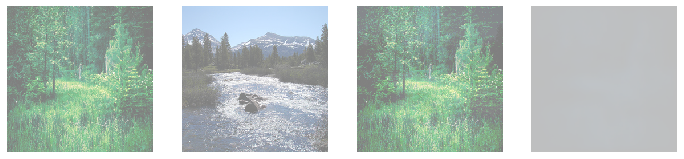

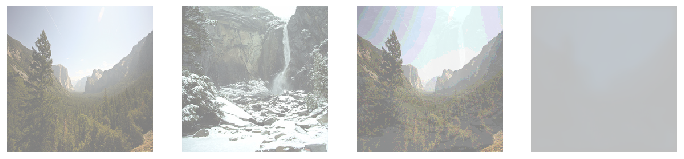

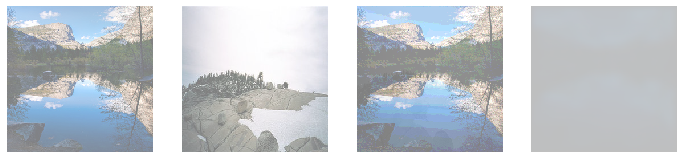

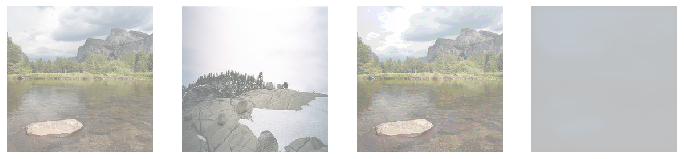

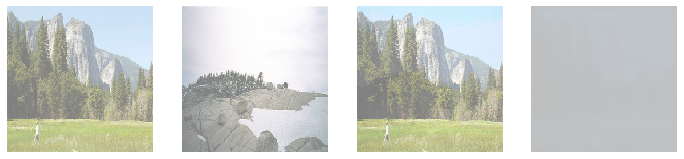

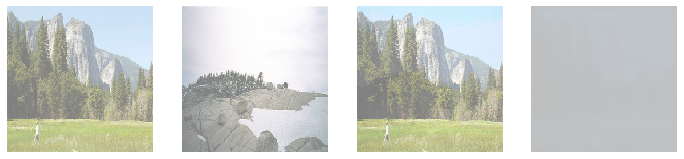

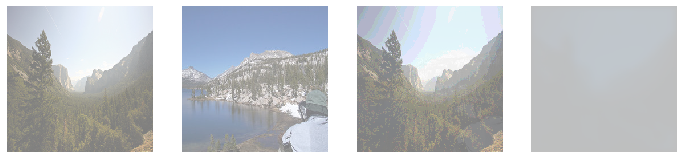

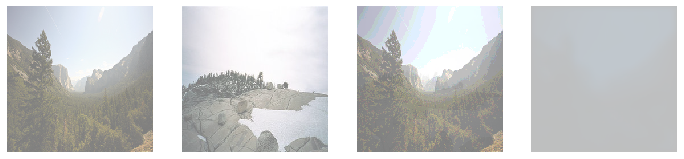

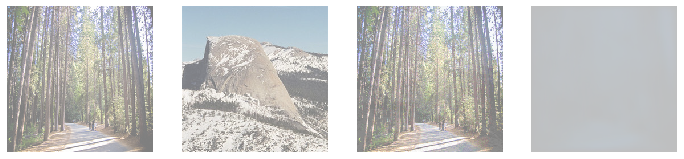

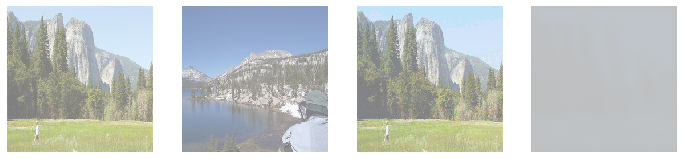

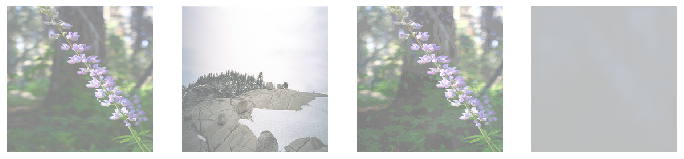

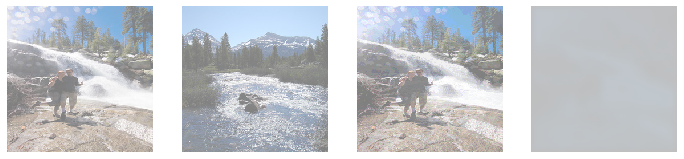

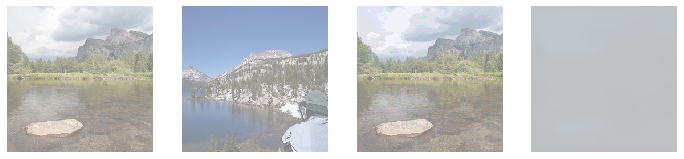

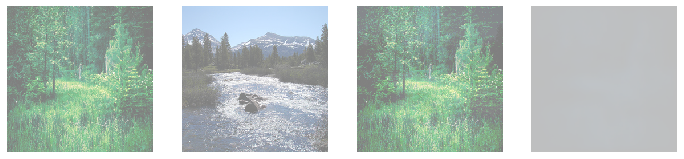

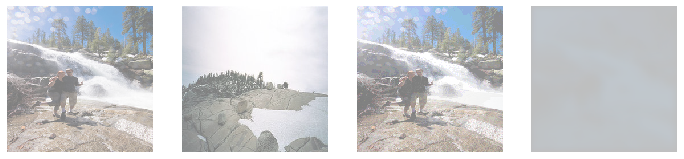

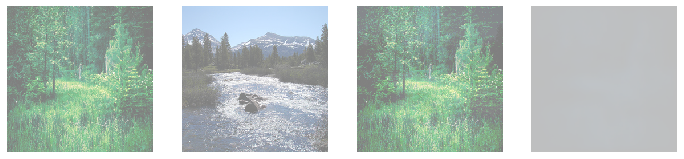

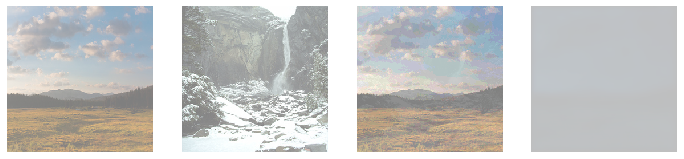

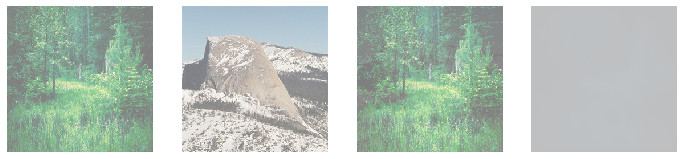

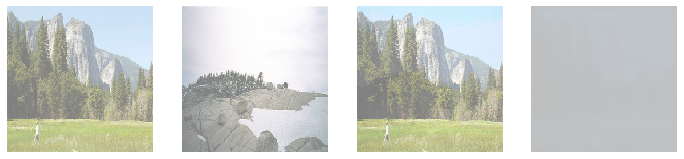

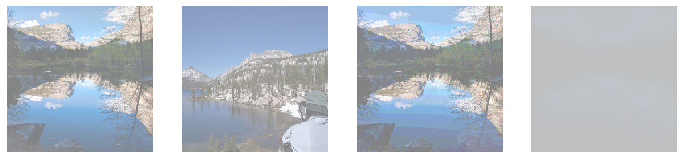

In [14]:
STEN_X_TEST = 5
for _ in range(20):
    set_1 = np.random.randint(1,11)
    set_2 = np.random.randint(1,6)
    name = str(set_1) + '_' + str(set_2)
    cover = os.getcwd() + "/data/set1/{0}.jpg".format(set_1)
    hidden = os.getcwd() + "/data/set2/{0}.jpg".format(set_2)
    encoded = np.load(os.getcwd() + "/encodedArray/bit_{0}/{1}.npy".format(STEN_X_TEST, name)) / 255.0
    decoded = np.load(os.getcwd() + "/decodedArray/bit_{0}/{1}.npy".format(STEN_X_TEST, name))
    predicted = autoencoder.predict(np.asarray([encoded]))
    generate_images(mpimg.imread(cover)/255.0, mpimg.imread(hidden)/255.0, encoded, predicted[0])